In [103]:
# notebook last tested with abtem version 1.0.0beta8

from abtem import __version__
print('current version:', __version__)

from abtem import *
from abtem.plot import show_atoms
from ase.io import read

from ase.cluster import wulff_construction
from ase import Atoms

current version: 1.0.0beta8


# HRTEM simulation of nanoparticle

We set up an nanoparticle with ASE. THe nanoparticle is rotated to align with the <110> zone axis.

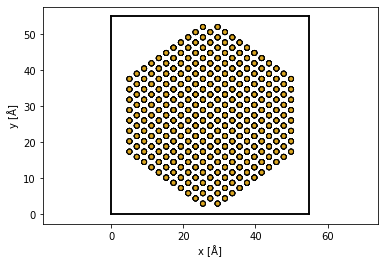

In [93]:
surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]

esurf = [1.0, 1.1, 0.9]

size = 3000

atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above'))

atoms.center(vacuum=5)

atoms.rotate(45, 'x', center='cop')

show_atoms(atoms)

We create and calculate the electrostatic potential. In this example, we use the infinite projection scheme for speed.

In [94]:
potential = Potential(atoms, 
                      gpts=512, 
                      slice_thickness=1, 
                      parametrization='kirkland', 
                      projection='infinite')

In [95]:
# To simulate TDS uncomment below

#sigmas = {'Au': .1} # standard deviations of thermal vibrations
#num_configs = 30 # number of frozen phonon configurations

#frozen_phonons = FrozenPhonons(atoms, num_configs=32, sigmas=sigmas)
#potential = Potential(frozen_phonons, gpts=1024, slice_thickness=1, parametrization='kirkland', projection='infinite')

We create the incoming plane wave and start the multislice simulation.

In [96]:
wave = PlaneWave(
    energy=300e3 # acceleration voltage in eV
)

exit_wave = wave.multislice(potential)

We can get the complex exit wave function as an array.

In [97]:
exit_wave.array.shape

(1, 512, 512)

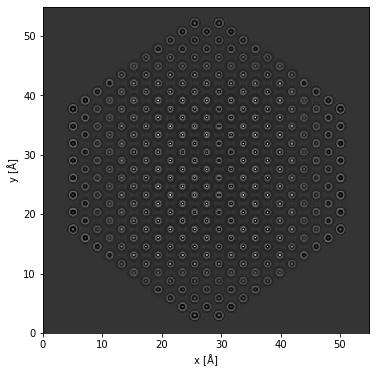

In [98]:
exit_wave.intensity().mean(0).show(figsize=(6,6));

We create and show the contrast transfer function, see [docs](https://abtem.readthedocs.io/en/latest/walkthrough/05_contrast_transfer_function.html).

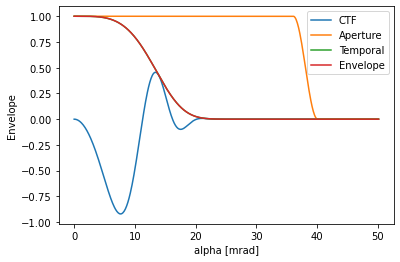

In [99]:
ctf = CTF(
    energy = wave.energy,
    semiangle_cutoff = 40, # mrad
    focal_spread = 60, # Å
    defocus = -160, # Å
    Cs = -7e-6 * 1e10, # Å
)

ctf.show(50);

To simulate an image we apply the contrast transfer function of the objective lens. 

Note, how we have take the mean across the first axis after calculating the intensity to get the mean of the thermal (if frozen phonons were included).

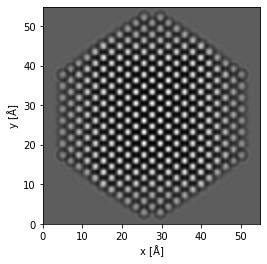

In [100]:
image_wave = exit_wave.apply_ctf(ctf)

image_wave.intensity().mean(0).show();

We get the diffraction pattern up to a chosen scattering angle.

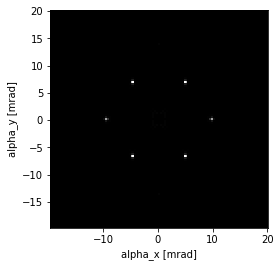

In [101]:
image_wave.diffraction_pattern(max_angle=20, block_zeroth_order=3, ).show();

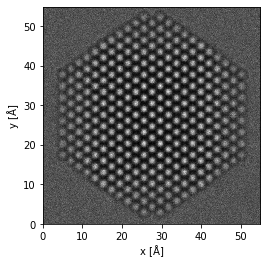

In [102]:
from abtem.noise import poisson_noise

measurement = image_wave.intensity()
noisy_measurement = poisson_noise(measurement, 5000)

noisy_measurement.show();